# SF Crime PSET 1

1. [Introduction](#intro)
2. [Getting the Data](#data)
3. [Descriptive Statistics](#stats)
4. [Geographic Information Systems](#gis)
5. [Discussion Questions](#dq)

In [1]:
# imports
import requests
from datascience import *
import matplotlib.pyplot as plt
import datetime
import folium
from folium import GeoJson
import time
import json
import os
from branca.colormap import linear
import branca.colormap
import pandas as pd
%matplotlib inline

## 1. Introduction <a id='intro'></a>

For this lab, we will be working with the San Francisco Police Department's Incident Database. The dataset contains up-to-date information on incidents reported to the SFPD. Each observation is tagged with information about the incident's location, type of infraaction, and date/time. In this lab you will:

1. Download the data through an Application Programming Interface (API)
2. Explore the data with summary and descriptive statistics
3. Map the incidents

Make sure to start early and ask lots of questions! The dataset, along with other publicaly available data, is available at: https://data.sfgov.org/Public-Safety/Police-Department-Incidents/tmnf-yvry

## 2. Getting the Data <a id='data'></a>

Write code that pulls the data into your environment with an API call. Here is the link to the API: https://data.sfgov.org/resource/PdId.json

In [12]:
df = pd.read_csv("Police_Department_Sample_Incidents.csv").drop("location", axis=1)
data = Table.read_table("Police_Department_Sample_Incidents.csv").drop("location")
data

incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,pdid
30325834,OTHER OFFENSES,POSSESSION OF BURGLARY TOOLS,Wednesday,03/19/2003,01:06:00,MISSION,"ARREST, BOOKED",3100 Block of CESAR CHAVEZ ST,-122.413,37.7482,3.03258e+12
150119979,OTHER OFFENSES,TRAFFIC VIOLATION,Sunday,02/08/2015,03:26:00,INGLESIDE,"ARREST, BOOKED",MISSION ST / COLLEGE AV,-122.425,37.7354,1.5012e+13
130507219,OTHER OFFENSES,RESISTING ARREST,Thursday,06/20/2013,15:22:00,CENTRAL,"ARREST, CITED",200 Block of SACRAMENTO ST,-122.398,37.7944,1.30507e+13
40459865,OTHER OFFENSES,LOST/STOLEN LICENSE PLATE,Wednesday,04/21/2004,11:00:00,INGLESIDE,NONE,600 Block of 28TH ST,-122.437,37.7448,4.04599e+12
70067529,FORGERY/COUNTERFEITING,"CHECKS, MAKE OR PASS FICTITIOUS",Friday,01/05/2007,12:00:00,INGLESIDE,NONE,1600 Block of BURROWS ST,-122.419,37.7249,7.00675e+12
106103162,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,08/19/2010,14:05:00,BAYVIEW,NONE,1300 Block of REVERE AV,-122.386,37.729,1.06103e+13
120276214,ASSAULT,BATTERY WITH SERIOUS INJURIES,Saturday,04/07/2012,03:05:00,PARK,"ARREST, BOOKED",500 Block of CENTRAL AV,-122.445,37.7746,1.20276e+13
170096642,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Friday,02/03/2017,15:00:00,MISSION,NONE,400 Block of CASTRO ST,-122.435,37.7618,1.70097e+13
40822096,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,07/19/2004,13:00:00,TENDERLOIN,"ARREST, CITED",EDDY ST / HYDE ST,-122.416,37.7835,4.08221e+12
100487776,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Friday,05/07/2010,20:30:00,SOUTHERN,NONE,400 Block of MINNA ST,-122.407,37.7811,1.00488e+13


<font color='blue'><b>QUESTION: What are the advantages to downloading data this way, instead of with a point-and-click action?</b></font>

_Type your answer here, replacing this text._

## 3. Descriptive Statistics <a id='stats'></a>

Plot the number of incidents per year from 2000-2017 (choose the appropriate type of plot). Have crime rates increased or decreased in general? 

In [13]:
# creating a year column from the first four characters of the 'date' column
data['year'] = pd.DatetimeIndex(df['date']).year
data

incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,pdid,year
30325834,OTHER OFFENSES,POSSESSION OF BURGLARY TOOLS,Wednesday,03/19/2003,01:06:00,MISSION,"ARREST, BOOKED",3100 Block of CESAR CHAVEZ ST,-122.413,37.7482,3.03258e+12,2003
150119979,OTHER OFFENSES,TRAFFIC VIOLATION,Sunday,02/08/2015,03:26:00,INGLESIDE,"ARREST, BOOKED",MISSION ST / COLLEGE AV,-122.425,37.7354,1.5012e+13,2015
130507219,OTHER OFFENSES,RESISTING ARREST,Thursday,06/20/2013,15:22:00,CENTRAL,"ARREST, CITED",200 Block of SACRAMENTO ST,-122.398,37.7944,1.30507e+13,2013
40459865,OTHER OFFENSES,LOST/STOLEN LICENSE PLATE,Wednesday,04/21/2004,11:00:00,INGLESIDE,NONE,600 Block of 28TH ST,-122.437,37.7448,4.04599e+12,2004
70067529,FORGERY/COUNTERFEITING,"CHECKS, MAKE OR PASS FICTITIOUS",Friday,01/05/2007,12:00:00,INGLESIDE,NONE,1600 Block of BURROWS ST,-122.419,37.7249,7.00675e+12,2007
106103162,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,08/19/2010,14:05:00,BAYVIEW,NONE,1300 Block of REVERE AV,-122.386,37.729,1.06103e+13,2010
120276214,ASSAULT,BATTERY WITH SERIOUS INJURIES,Saturday,04/07/2012,03:05:00,PARK,"ARREST, BOOKED",500 Block of CENTRAL AV,-122.445,37.7746,1.20276e+13,2012
170096642,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Friday,02/03/2017,15:00:00,MISSION,NONE,400 Block of CASTRO ST,-122.435,37.7618,1.70097e+13,2017
40822096,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,07/19/2004,13:00:00,TENDERLOIN,"ARREST, CITED",EDDY ST / HYDE ST,-122.416,37.7835,4.08221e+12,2004
100487776,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Friday,05/07/2010,20:30:00,SOUTHERN,NONE,400 Block of MINNA ST,-122.407,37.7811,1.00488e+13,2010


In [14]:
agg_on_year = data.group('year')
agg_on_year.show()

year,count
2003,686
2004,715
2005,646
2006,632
2007,630
2008,671
2009,656
2010,585
2011,635
2012,634


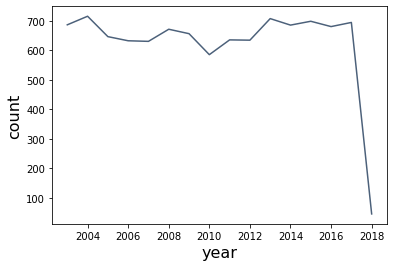

In [15]:
agg_on_year.plot('year', 'count')

Looking just at 2017, what proportion of the total does each type of crime constitute? Use at least one table and at least one plot to support your answer.

In [16]:
agg_by_crime = data.where('year', 2017).group('category')
agg_by_crime['proportion'] = [count / sum(agg_by_crime.column('count')) for count in agg_by_crime.column('count')]
agg_by_crime.sort('proportion', descending=True)

category,count,proportion
LARCENY/THEFT,210,0.302594
NON-CRIMINAL,72,0.103746
ASSAULT,71,0.102305
OTHER OFFENSES,70,0.100865
VANDALISM,48,0.0691643
BURGLARY,29,0.0417867
SUSPICIOUS OCC,28,0.0403458
WARRANTS,26,0.037464
VEHICLE THEFT,23,0.0331412
MISSING PERSON,22,0.0317003


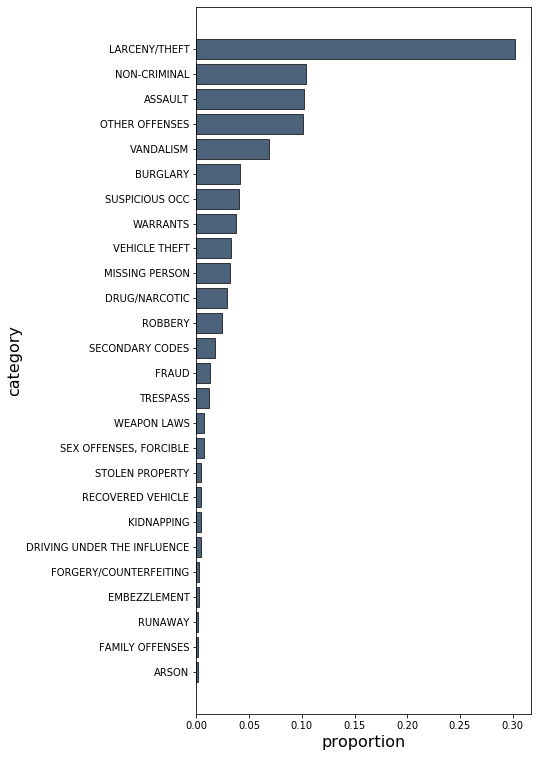

In [17]:
agg_by_crime.sort('count', descending=True).barh('category', 'proportion')

Is there a relationship between day of week, time, and whether an incident occurs? Bonus: Is there a relationship between day/time and particular types of incidents?

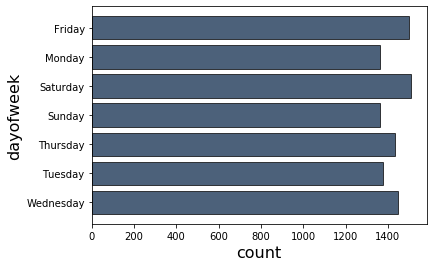

In [18]:
data.group('dayofweek').barh('dayofweek')

In [19]:
# making an hour column that can be grouped on
data['hour'] = [int(t[:2]) for t in data['time']]

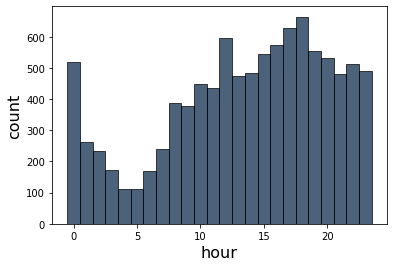

In [20]:
data.group('hour').bar('hour')

#### Bonus: Are there any other interesting relationships in the data?

_Type your answer here, replacing this text._

# 4. Geographic Information Systems (GIS) <a id='gis'></a>

Plot individual incidents in 2017 as points on a map of San Francisco. Does crime seem randomly distributed in space, or do incidents tend to cluster close together? Propose an explanation for your conclusion. Bonus: Shade the points by type of crime.

Hint: Use the `basemap` extension to the `matplotlib` package!

In [23]:
twentyeighteen = data.where('year' == 2018).sample(1000)
twentyeighteen['y'] = twentyeighteen['y'].astype('float')
twentyeighteen['x'] = twentyeighteen['x'].astype('float')

In [24]:
mp = folium.Map(location=[37.7749, -122.4194])
for coords in list(zip(twentyeighteen['y'], twentyeighteen['x'])):
    folium.Marker(
        location=coords
    ).add_to(mp)
mp

In [25]:
from folium.plugins import HeatMap

mp = folium.Map(location=[37.7749, -122.4194])
HeatMap(list(zip(twentyeighteen['y'], twentyeighteen['x']))).add_to(mp)
mp

Merge the incidents data with either a Shapefile or GeoJSON file with information on the boundaries of neighborhoods in San Francisco. 

The neighborhood data is available here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

The API endpoint: https://data.sfgov.org/resource/xfcw-9evu.json

*.geojson

In [ ]:
#import requests
#r = requests.get(url='https://data.sfgov.org/resource/xfcw-9evu.json')

In [26]:
sf_neighborhoods = os.path.join('SF Find Neighborhoods.geojson')
geo_json_data = json.load(open(sf_neighborhoods))

In [27]:
m = folium.Map([37.7749, -122.4194], zoom_start = 12)
m

In [28]:
# might be too big bc won't display
m = folium.Map(
    location=[37.7749, -122.4194], zoom_start = 12
)

folium.GeoJson(geo_json_data
).add_to(m)
m

Construct a choropleth map, coloring in each neighborhood by how many incidents it had in 2018. Bonus: Construct several maps that explore differences by day of week, time of year, time of day, etc.

In [44]:
crime_neighborhood_agg = pd.read_csv("crime_neighborhood_agg.csv")
crime_neighborhood_agg.head()

,neighborhood,crimes
0,Alamo Square,7
1,Anza Vista,2
2,Apparel City,4
3,Aquatic Park / Ft. Mason,3
4,Ashbury Heights,1


Do you notice any patters? Are there particular neighborhoods where crime concentrates more heavily?

In [45]:
m = folium.Map(
    location=[37.7749, -122.4194], zoom_start = 12
)

m.choropleth(
    geo_data=geo_json_data,
    data=crime_neighborhood_agg,
    columns=['neighborhood', 'crimes'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    threshold_scale=[0, 10, 60, 100, 140],
    highlight=True
    )

m

# 5. Discussion Questions <a id='dq'></a>

Based on the evidence from this lab assignment, why do you think "hot spots" policing became more popular in the last few decades? What are the pros and cons to this kind of approach?

What other sorts of data would help improve your analysis?

_Type your answer here, replacing this text._